In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Class 16: Real and Nominal Business Cycle Data

In this notebook, we will briefly explore US macroeconomic data suggesting that, contrary to the assumptions of most RBC models, there is in fact a relationship between real and nominal quantities over the business cycle. We will estimate an aggregate supply equation for the US and a monetary policy rule for the FOMC.

## Data

The file `business_cycle_data_actual_trend_cycle.csv`, available at https://raw.githubusercontent.com/letsgoexploring/economic-data/master/business-cycle-data/csv/business_cycle_data_actual_trend_cycle.csv, contains actual and trend data for real GDP per capita, real consumption per capita, real investment per capita, real physical capital per capita, TFP, hours per capita, the rea money supply (M2), (nominal) interest rate on 3-month T-bills, the PCE inflation rate, and the unemployment rate; each at quarterly frequency. The GDP, consumption, investment, capital, and money supply data are in terms of 2012 dollars. Hours is measured as an index with the value in October 2012 set to 100.

In [2]:
# Read business_cycle_data_actual_trend.csv into a Pandas DataFrame with the first column set as the index and parse_dates=True
data = pd.read_csv('https://raw.githubusercontent.com/letsgoexploring/economic-data/master/business-cycle-data/csv/business_cycle_data_actual_trend_cycle.csv',index_col=0,parse_dates=True)

# Print the last five rows of the data
data.tail()

,gdp,gdp_trend,gdp_cycle,consumption,consumption_trend,consumption_cycle,investment,investment_trend,investment_cycle,hours,...,real_m2_cycle,t_bill_3mo,t_bill_3mo_trend,t_bill_3mo_cycle,pce_inflation,pce_inflation_trend,pce_inflation_cycle,unemployment,unemployment_trend,unemployment_cycle
date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,71.884959,73.083927,-0.016541,48.422718,49.598329,-0.023988,13.130728,12.985902,0.011091,99.645575,...,0.047491,0.000933,0.007265,-0.006332,0.011897,0.025293,-0.013396,0.067667,0.054270,0.013397
2021-01-01,73.031372,73.261561,-0.003147,49.725788,49.748428,-0.000455,13.016749,13.029610,-0.000988,100.676809,...,0.053418,0.000500,0.006384,-0.005884,0.018304,0.026817,-0.008513,0.062000,0.054958,0.007042
2021-04-01,74.146585,73.444384,0.009516,51.129965,49.903431,0.024281,12.797634,13.075134,-0.021452,102.026701,...,0.051023,0.000267,0.005486,-0.005219,0.038614,0.028407,0.010207,0.059000,0.055572,0.003428
2021-07-01,74.456430,73.630379,0.011156,51.231561,50.061144,0.023111,13.155543,13.122045,0.002550,103.686198,...,0.037467,0.000467,0.004578,-0.004112,0.042778,0.030034,0.012744,0.051000,0.056132,-0.005132
2021-10-01,75.605974,73.817949,0.023933,51.442574,50.220111,0.024051,14.174733,13.169729,0.073540,104.144713,...,0.024760,0.000533,0.003667,-0.003134,0.054946,0.031675,0.023271,0.042333,0.056663,-0.014329


### Exercise: GDP and Inflation

Construct a plot of the cyclical components of GDP and inflation. 

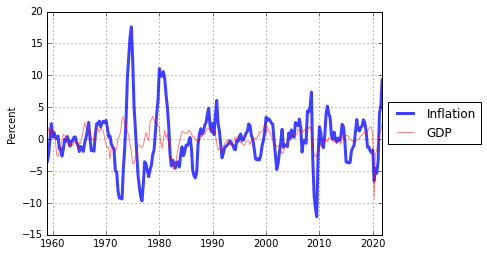

In [3]:
# Construct plot
plt.plot(data['pce_inflation_cycle']*400,alpha=0.75,lw=3,label='Inflation')
plt.plot(data['gdp_cycle']*100,c='r',alpha=0.5,label='GDP')

plt.ylabel('Percent')
plt.grid()

# Place legend to right of figure. PROVIDED
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Exercise: GDP and the 3-Month T-Bill Rate

Construct a plot of the cyclical components of GDP and the 3-month T-bill rate. 

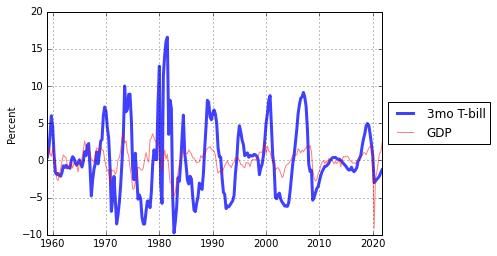

In [4]:
# Construct plot
plt.plot(data['t_bill_3mo_cycle']*400,alpha=0.75,lw=3,label='3mo T-bill')
plt.plot(data['gdp_cycle']*100,c='r',alpha=0.5,label='GDP')

plt.ylabel('Percent')
plt.grid()

# Place legend to right of figure. PROVIDED
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Standard Deviations and Correlations Between GDP, Inflation, and 3-Month T-Bill Rate

Compute the standard deviations of GDP, inflation, and the 3-month T-bill rate.

In [5]:
# Compute standard deviations
data[['gdp_cycle','pce_inflation_cycle','t_bill_3mo_cycle']].std()

gdp_cycle              0.015475
pce_inflation_cycle    0.010206
t_bill_3mo_cycle       0.011487
dtype: float64

Quarterly fluctuations of each series os the oder of 1 to 1.5 percent away from trend.

Next, compute the coefficients of corrrelation between GDP, inflation, and the 3-month T-bill rate.

In [6]:
# Compute correlation coefficients
data[['gdp_cycle','pce_inflation_cycle','t_bill_3mo_cycle']].corr()

,gdp_cycle,pce_inflation_cycle,t_bill_3mo_cycle
gdp_cycle,1.000000,0.188381,0.398358
pce_inflation_cycle,0.188381,1.000000,0.545655
t_bill_3mo_cycle,0.398358,0.545655,1.000000


Strong (but not perfect!) correlations between GDP and inflation and GDP and the T-bill rate suggest link between nominal and real quantities over the business cycle that should be exaplined by business cycle theory.

## Aggregate Supply

Contemporary business cycle models for monetary policy emphasize the importance of an upward-sloping aggreagate supply (AS) curve: a positive relationship between the cyclical components of output and inflation. We will uncover evidence of an upward-sloping AS curve for the US by estimating the following equation:

\begin{align}
\hat{\pi}_t & = \beta \hat{y}_t + \epsilon_t,
\end{align}

where $\hat{\pi}_t$ is the cyclical component of inflation, $\hat{y}_t$ is the cyclical component of real GDP for the US, and $\epsilon_t$ is the resudual of the regression. We do not estimate a constant because the data are mean 0.

Note that estimation exercise is subject to an endogeneity bias because output and inflation are in fact determined simultaneously in equilbrium. However, while the results we obtain my not be robust, they will be suggestive and that's enough for now.

First, make a scatter plot of inflation against GDP to verify that there appears to be a relationship worth estimating

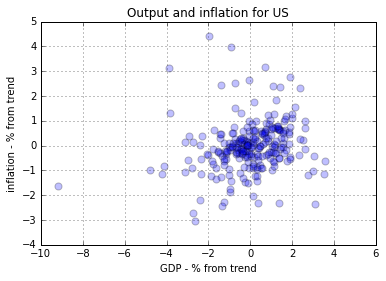

In [7]:
# Create figure and axis
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Scatter plot with poitn size of 50, opacity 0.25, and label of 'actual'
ax.scatter(data['gdp_cycle']*100,data['pce_inflation_cycle']*100,s=50,alpha=0.25,label='actual')

# Set x-axis limits to [-10,6]
ax.set_xlim([-10,6])

# Axis labels and title
ax.set_title('Output and inflation for US')
ax.set_xlabel('GDP - % from trend')
ax.set_ylabel('inflation - % from trend')

ax.grid()

### OLS Regression

In [8]:
# Import statsmodels.api
import statsmodels.api as sm

In [9]:
# Define variable 'X' to be equal to the cyclical component of real GDP
X = data['gdp_cycle']

# Define variable 'Y' to be equal to the cyclical component of inflation
Y = data['pce_inflation_cycle']

# Initialze the OLS model
model = sm.OLS(Y,X)

# Fit the OLS model
results = model.fit()

# Display estimation results
print(results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     pce_inflation_cycle   R-squared (uncentered):                   0.035
Model:                             OLS   Adj. R-squared (uncentered):              0.032
Method:                  Least Squares   F-statistic:                              9.231
Date:                 Sat, 04 Jun 2022   Prob (F-statistic):                     0.00263
Time:                         18:33:16   Log-Likelihood:                          802.83
No. Observations:                  252   AIC:                                     -1604.
Df Residuals:                      251   BIC:                                     -1600.
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Apparently, a one percent increase in GDP relative to trend corresponds with a 0.12 percent increase in the inflation rate.

### Plot results

Construct a scatter plot of the underelying data with the predicted values from the OLS regression.

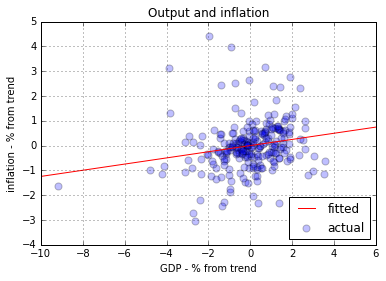

In [10]:
# Create variable 'x_values' as an array from -10 to 6
x_values = np.linspace(-10,6,4)

# Create variable 'y_values' using estimated value for beta
y_values = results.params['gdp_cycle']*x_values

# Create figure and axis
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Scatter plot with point size of 50, opacity 0.25, and label of 'actual'
ax.scatter(data['gdp_cycle']*100,data['pce_inflation_cycle']*100,s=50,alpha=0.25,label='actual')

# Plot estimated relationship as a red line with label of 'fitted'
ax.plot(x_values,y_values,'r',label='fitted')

# Set x-axis limits to [-10,6]
ax.set_xlim([-10,6])

# Axis labels and title
ax.set_title('Output and inflation')
ax.set_xlabel('GDP - % from trend')
ax.set_ylabel('inflation - % from trend')

# Legend in the lower right corner with scatterpoints=1
ax.legend(scatterpoints=1,loc='lower right')

# Grid
ax.grid()

## Taylor's Monetary Policy Rule

Central banks in many countries set monetary policy with at least some autonomy. In the US, the Federal Reserve has broad discretion to decide how to manage its federal funds rate target in response to changes in the economy. The Federal Open Market Committee (FOMC), the monetary policymaking body within the Fed, comprises members of the Board of Governors and a rotating group of presidents from five of the regional Federal Reserve Banks.

The members of the FOMC can vote to set policy how they like and the composition of the FOMC changes regularly. So it might seem that modeling the decisionmaking of the FOMC would not be fruitful. But in fact, evidence shows that the FOMC does behave in a remarkably systematic way.

In his article "Discretion versus policy rules in practice" in the December 1993 issue of the *Carnegie-Rochester Conference Series on Public Policy*, John Taylor shows that monetary policy in the US could be approximated by a simple linear equation. (link to article: https://www.sciencedirect.com/science/article/pii/016722319390009L). His equation is:

\begin{align}
\text{Federal funds rate} & = \text{Inflation} + 0.5\cdot \text{Output gap} + 0.5\cdot(\text{Inflation - 2}) + 2,
\end{align}

where *inflation* is the percent change in the GDP deflator over the previous year and *output gap* is the percent deviation of GDP from a "target rate". Taylor assumed a target rate consistent with a constant growth GDP path of 2.2%. Note that the coefficients on inflation sum to 1.5.

You can see how well Taylor's rule fit the data as of 1993 in this figure from his paper:

<br>

<div align="center">
 <figure style="display: table">
   <img src="https://raw.githubusercontent.com/letsgoexploring/econ126/master/Img/external_fig_16_Rules_v_Discretion_Taylor_Fig1.png" width="50%" height="50%"> 
  <figcaption style="display: table-caption; caption-side: top; text-align: center;" >Figure 1. <strong>Taylor's rule and the actual federal funds rate.</strong> Source: Taylor (1993)</figcaption>
</figure> 
</div>

<br>

Taylor doesn't estimate his equation precisely and it's remarkable that such a simple linear equation would even come close to matching policy. In this example, we will gather data to replicate Taylor's rule and estimate his rule using OLS.

### Federal Funds Rate

The federal funds are is the interest rate on overnight interbank loans. The FOMC sets a taget for the fed funds rate and implements monetary policy so that the actual (or *effective*) federal unds rate equals the FOMS's target. The effective federal funds rate has FRED series ID `FEDFUNDS` and is available here: https://fred.stlouisfed.org/series/FEDFUNDS. Notice that there are 62 lines of text *before* the line starting with "DATE".

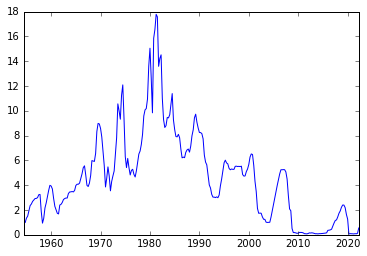

In [11]:
# Import federal funds rate data from FRED. Use arguments: sep='\s+',skiprows=62,index_col=0,parse_dates=True
fed_funds = pd.read_csv('https://fred.stlouisfed.org/data/FEDFUNDS.txt',sep='\s+',skiprows=62,index_col=0,parse_dates=True)

# Set fed_funds equal to 'VALUE' column of fed_funds
fed_funds = fed_funds['VALUE']

# Use .resample('QS').mean() method of 'fed_funds' to convert the fed funds data from monthdy to quarterly
fed_funds = fed_funds.resample('QS').mean()

# Plot the federal funds rate. PROVIDED
plt.plot(fed_funds)

# Inflation

Taylor computes the inflation rate as the percent change in the GDP deflator from one year prior:

\begin{align}
\text{Inflation}_t = \frac{\text{GDP deflator}_t - \text{GDP deflator}_{t-4}}{\text{GDP deflator}_{t-4}}\cdot 100
\end{align}

The GDP deflator has FRED series ID `GDPDEF` and is available here: https://fred.stlouisfed.org/series/GDPDEF. Notice that there are 15 lines of text *before* the line starting with "DATE".

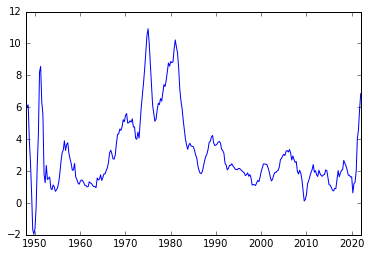

In [12]:
# Import GDP deflator data from FRED. PROVIDED
deflator = pd.read_csv('https://fred.stlouisfed.org/data/GDPDEF.txt',sep='\s+',skiprows=15,index_col=0,parse_dates=True)

# Set deflator equal to 'VALUE' column of deflator. PROVIDED
deflator = deflator['VALUE']

# Compute the inflation rate
inflation = (deflator - deflator.shift(4))/deflator.shift(4)*100

# Plot the inflation rate data. PROVIDED
plt.plot(inflation)

### Output gap

The output gap is measured as the percent difference of real GDP from the CBO's estimate of the potential real GDP:

\begin{align}
\text{Output gap} & = \left(\frac{\text{Real GDP}-\text{Real potential GDP}}{\text{Real potential GDP}}\right)\cdot 100
\end{align}

Real GDP has FRED series ID `GDPC1` and is available here: https://fred.stlouisfed.org/series/GDPC1. Notice that there are 17 lines of text *before* the line starting with "DATE".

In [13]:
# Import real GDP data from FRED. PROVIDED
gdp_actual = pd.read_csv('https://fred.stlouisfed.org/data/GDPC1.txt',sep='\s+',skiprows=17,index_col=0,parse_dates=True)

# Set gdp_actual equal to 'VALUE' column of gdp_actual. PROVIDED
gdp_actual = gdp_actual['VALUE']

Potential real GDP has FRED series ID `GDPPOT` and is available here: https://fred.stlouisfed.org/series/GDPPOT. Notice that there are 12 lines of text *before* the line starting with "DATE".

In [14]:
# Import potential real GDP data from FRED. PROVIDED
gdp_potential = pd.read_csv('https://fred.stlouisfed.org/data/GDPPOT.txt',sep='\s+',skiprows=12,index_col=0,parse_dates=True)

# Set gdp_potential equal to 'VALUE' column of gdp_potential. PROVIDED
gdp_potential = gdp_potential['VALUE']

Text(0.5, 1.0, 'Real GDP')

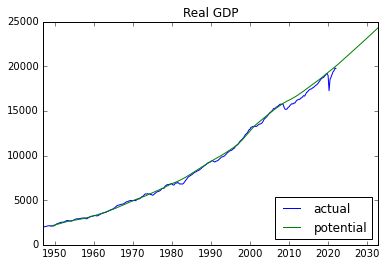

In [15]:
# Plot the actual and potential real GDP data with a legend. CELL PROVIDED
plt.plot(gdp_actual,label='actual')
plt.plot(gdp_potential,label='potential')
plt.legend(loc='lower right')
plt.title('Real GDP')

### Combine Data into a DataFrame

In [16]:
# Create variable 'df' that is a DataFrame storing fed funds, inflation, actual and potential real GDP
df = pd.DataFrame({
    'fed_funds':fed_funds,
    'inflation':inflation,
    'gdp_actual':gdp_actual,
    'gdp_potential':gdp_potential
})

# Drop missing values from 'df'
df = df.dropna()

df

,fed_funds,inflation,gdp_actual,gdp_potential
DATE,,,,
1954-07-01,1.030000,0.726141,2684.434,2723.565467
1954-10-01,0.986667,0.814523,2736.960,2740.801463
1955-01-01,1.343333,0.963325,2815.134,2757.537544
1955-04-01,1.500000,1.292452,2860.942,2775.486948
1955-07-01,1.940000,1.867491,2899.578,2793.073369
...,...,...,...,...
2021-01-01,0.080000,2.034478,19055.655,19644.490000
2021-04-01,0.070000,4.035123,19368.310,19732.990000
2021-07-01,0.090000,4.589597,19478.893,19822.820000


<AxesSubplot:xlabel='DATE'>

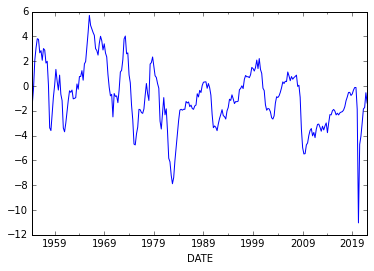

In [17]:
# Construct an output gap column
df['output_gap'] = (df['gdp_actual'] - df['gdp_potential'])/df['gdp_potential']*100
df['output_gap'].plot()

Recall Taylor's rule:

\begin{align}
\text{Federal funds rate} & = \text{Inflation} + 0.5\cdot \text{Output gap} + 0.5\cdot(\text{Inflation - 2}) + 2
\end{align}

In [18]:
# Construct a column called 'taylor' that implements Taylor's rule
df['taylor'] = df['inflation'] + 0.5*df['output_gap'] + 0.5*(df['inflation']-2)+2

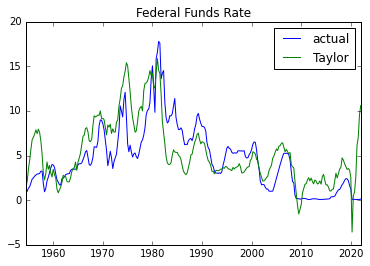

In [19]:
# Plot actual federal funds rate and the federal funds rate implied by Taylor's rule. CELL PROVIDED
plt.plot(df['fed_funds'],label='actual')
plt.plot(df['taylor'],label='Taylor')
plt.title('Federal Funds Rate')
plt.legend()

### OLS Model of the FOMC's Monetary Policy Rule

Following the format suggested by Taylor's rule, we'll estimate the following monetary policy rule for the US:

\begin{align}
\hat{i}_t & = \bar{\imath} + \phi_{\pi}\pi_t + \phi_{y} y_t + \epsilon_t
\end{align}

where $\pi_t$ is the percent change in the GDP deflator over the previous year and $y_t$ is the output gap measured as the percent difference of real GDP from the CBO's estimate of the potential real GDP. $\phi_{\pi}$ is the weight that the FOMC places on inflation in the rule and $\phi_{y}$ is the weight that the central bank places on the output gap. $\epsilon_t$ is the residual of the regression. 

In [20]:
# Create variable 'X' with columns inflation, output and a constant
X = sm.add_constant(df[['inflation','output_gap']])

# Create variable 'Y' equal to the federal funds rate
Y = df['fed_funds']

# Initialize OLS model
model = sm.OLS(Y,X)

# Fit OLS model
results = model.fit()

# Print regression results
print(results.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.529    
Dependent Variable: fed_funds        AIC:                1263.5297
Date:               2022-06-04 18:33 BIC:                1274.3360
No. Observations:   271              Log-Likelihood:     -628.76  
Df Model:           2                F-statistic:        152.8    
Df Residuals:       268              Prob (F-statistic): 5.28e-45 
R-squared:          0.533            Scale:              6.1324   
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const         1.0306     0.2692    3.8283   0.0002   0.5006   1.5606
inflation     1.1679     0.0677   17.2518   0.0000   1.0346   1.3012
output_gap    0.1637     0.0621    2.6368   0.0089   0.0415   0.2859
------------------------------------------------------------------
O

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The estimated constant in the regression is about 0.94 compared with 1 in Taylor's rule. The estimated coefficnets on inflation and the output gap are 1.22 and 0.12 compared with 1.5 and 0.5 in Taylor's rule. All three parameter estimates are remarkably close to Taylor's proposal. It's amazing that his rule still preforms will after almost 30 years.

Note, Taylor doens't argue that his rule is *optimal* in the sense that it is the best way for the FOMC to meet it's objectives. But there is evidence that it is actually very close to an optimal rule and therefore evidence that the FOMC does in fact tend to make good policy decisions.

In [21]:
# Add column 'fed_funds_predicted' to df equal to predicted fed funds rate values from regression
df['fed_funds_predicted'] = results.predict()

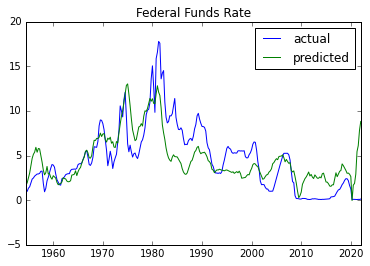

In [22]:
# Plot actual federal funds rate and the predicted federal funds. CELL PROVIDED
plt.plot(df['fed_funds'],label='actual')
plt.plot(df['fed_funds_predicted'],label='predicted')
plt.title('Federal Funds Rate')
plt.legend()